In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pyspark.sql.functions as f
from pyspark.sql.functions import col,avg
from pyspark.sql.types import StructType, StructField, StringType, FloatType
import numpy as np

sc = SparkContext()
sqlContext=SQLContext(sc)

sdf = sqlContext.read.csv("./data/tracks_features.csv", header=True, inferSchema=True)
pldf = sqlContext.read.csv("./data/playlists.csv",header=True, inferSchema=True)

23/01/10 00:30:14 WARN Utils: Your hostname, Erics-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.2.148 instead (on interface en0)
23/01/10 00:30:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/10 00:30:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


/Users/erka/opt/anaconda3/envs/spotify/lib/python3.11/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Preprocessing: 
* Remove Nan values (unsuccessfully parsed entries) 
* Rename columns consistently
* separate comma-separated artists --> give each artist-song combination one entry
* remove entries with nonsensical release-year 
* cast numeric columns to correct type

In [2]:
pldf = pldf.dropna() #12902577 --> 12868945
sdf = sdf.dropna()

pldf = pldf.withColumnRenamed(' "artistname"',"artist") \
    .withColumnRenamed("user_id","user") \
    .withColumnRenamed(' "trackname"',"track") \
    .withColumnRenamed(' "playlistname"',"playlist")

sdf = sdf.drop("artist_ids", "album_id") \
    .withColumnRenamed("artists","artist") \
    .withColumnRenamed("name","track")
sdf = sdf.withColumn("artist", f.split(col("artist"), ",")) \
        .withColumn("artist", f.explode(col("artist"))) \
        .withColumn("artist",f.trim(col("artist"))) \
        .withColumn("artist", f.translate(col("artist"),"[]\"'",""))
sdf= sdf.withColumn("year", f.trim(col("year"))) \
                  .withColumn("year", col("year").cast("integer")) \
                  .where(~f.isnull(col("year")))
sdf = sdf.where((col("year") >= 1800) & (col("year") <= 2022)) # years that make no sense
sdf = sdf.orderBy(f.desc("year"))


#set correct datatypes
columns_to_cast = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]
for column in columns_to_cast:
    sdf = sdf.withColumn(column, col(column).cast("float"))

Join both datasets on the name of the artist and the track

In [3]:
merge_df = pldf.join(sdf, on = ["artist","track"],how = "left") # 13918877 entries
merge_df = merge_df.dropna().persist() #2727713 entries

In [4]:
merge_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- track: string (nullable = true)
 |-- user: string (nullable = true)
 |-- playlist: string (nullable = true)
 |-- id: string (nullable = true)
 |-- album: string (nullable = true)
 |-- track_number: string (nullable = true)
 |-- disc_number: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: float (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- duration_ms: float (nullable = true)
 |-- time_signature: float (nullable = true)
 |-- year: integer (nullable = true)
 |-- release_date: string (nullable = true)



Calculate some general statistics

In [5]:
num_tracks = merge_df.select("track").distinct().count()
num_artists = merge_df.select("artist").distinct().count()
num_rows = merge_df.count()
print(num_tracks,num_artists,num_rows) # 147538 19759 2727713

147280 19732 2726346


Generate new Dataframes:
* averages over time
* averages over playlists
* add column for song popularity (how many distinct playlists song is in)
* add column for artist popularity (how many distinct playlists artist is in)

In [6]:

grouped = sdf.groupBy("year")
sdf_avg = grouped.avg("danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature").orderBy(f.desc("year"))
sdf_max = grouped.max("danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature").orderBy(f.desc("year"))
sdf_min = grouped.min("danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature").orderBy(f.desc("year"))
pl_avg = merge_df.groupBy("playlist").avg("danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature")
artist_popularity = merge_df.select("artist", "playlist").distinct().groupBy("artist").count().orderBy(f.desc("count"))
song_popularity = merge_df.select("track", "playlist").distinct().groupBy("track").count().orderBy(f.desc("count"))
merge_pop = merge_df.join(artist_popularity, on="artist", how="left").withColumnRenamed("count", "artist_popularity")
merge_pop = merge_pop.join(song_popularity, on="track", how="left").withColumnRenamed("count", "song_popularity")

data = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]
magic_percentile = f.expr('percentile_approx(val, 0.5)')
median_data = []
for d in data:
    median=grouped.agg(f.percentile_approx(d, 0.5,f.lit(1000000)).alias("median")).toPandas()["median"]
    median_data.append(np.array(median))

What are the most popular artists and songs? 
Popularity := how many distinct playlists a song/artist is included in

In [7]:
print(song_popularity.toPandas().head(10))
print(artist_popularity.toPandas().head(10))

                           track  count
0                          Creep   1565
1                         Ho Hey   1551
2                           Kids   1343
3  Rather Be (feat. Jess Glynne)   1279
4               Do I Wanna Know?   1204
5                     Chandelier   1195
6                           Sail   1144
7           Don't Stop Believin'   1121
8                          Magic   1121
9                          Happy   1120


              artist  count
0            Beyoncé   3476
1          Radiohead   3406
2     Arctic Monkeys   3038
3           Coldplay   2855
4    Michael Jackson   2593
5               MGMT   2516
6          Bob Dylan   2307
7       Foo Fighters   2212
8        The Strokes   2189
9  Bruce Springsteen   2131


In [8]:
# get num of unique artists
merge_df.select('artist').distinct().count()#.show()

19732

In [9]:
# most songs per artist
merge_df.select("artist", "track").distinct().groupBy("artist").count().orderBy(f.desc("count")).toPandas().head(10)

,artist,count
0,Johann Sebastian Bach,1565
1,Vitamin String Quartet,1128
2,Wolfgang Amadeus Mozart,411
3,Guided By Voices,393
4,Rockabye Baby!,333
5,Ludwig van Beethoven,333
6,Bob Dylan,325
7,Claude Debussy,321
8,Aretha Franklin,298
9,Robert Pollard,277


In [10]:
# get avg song duration
merge_df.agg(avg('duration_ms')).toPandas().head(10)

,avg(duration_ms)
0,246347.991325


In [11]:
# get num of minor/major songs
merge_df.groupBy('mode').count().toPandas().head()

,mode,count
0,1.0,1905292
1,0.0,821054


In [12]:
# get num of explicit songs
merge_df.groupBy('explicit').count().toPandas().head()

,explicit,count
0,False,2594936
1,True,131410


In [13]:
# get num of songs in diff keys
merge_df.groupBy('key').count().orderBy(f.asc("key")).toPandas().head(20)

,key,count
0,0.0,361396
1,1.0,206227
2,2.0,297276
3,3.0,72837
4,4.0,254970
5,5.0,218901
6,6.0,190787
7,7.0,319640
8,8.0,145228
9,9.0,296657


<AxesSubplot: >

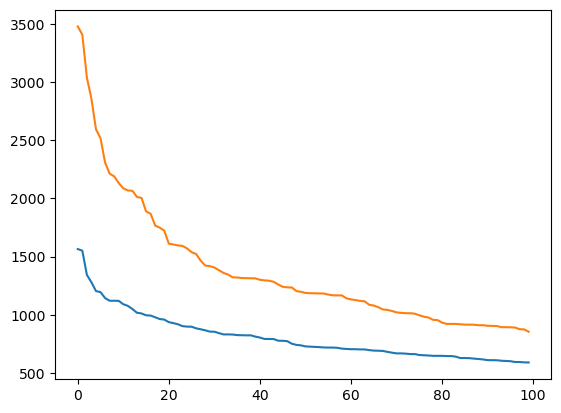

In [14]:
import matplotlib.pyplot as plt

song_popularity.toPandas()["count"][:100].plot()
artist_popularity.toPandas()["count"][:100].plot()

### Attributes over time
Average over numeric attributes

23/01/10 00:31:53 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


23/01/10 00:31:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/10 00:31:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/10 00:31:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/10 00:31:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/10 00:31:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/10 00:31:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/10 00:31:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/10 00:31:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/10 00:31:57 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/10 00:31:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


0     2020
1     2019
2     2018
3     2017
4     2016
      ... 
95    1920
96    1917
97    1909
98    1908
99    1900
Name: year, Length: 100, dtype: int32


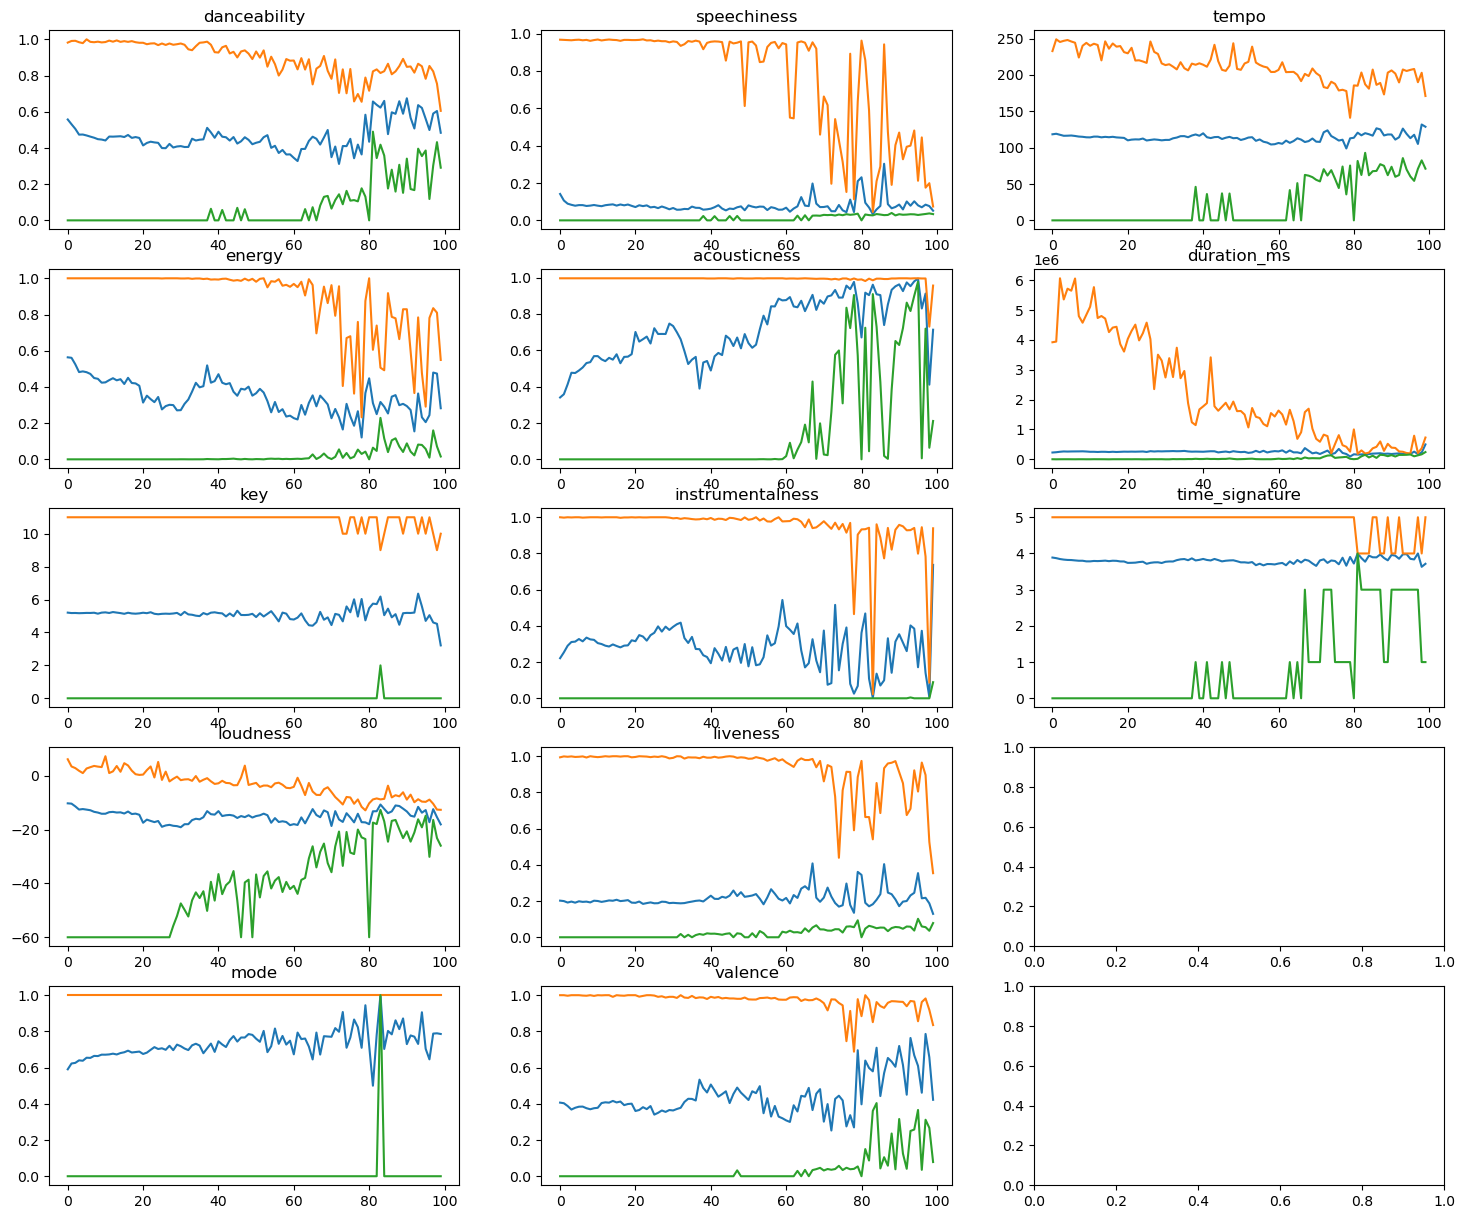

In [15]:
time_pandas = sdf_avg.toPandas()
print(time_pandas["year"])
time_pandas_max = sdf_max.toPandas()
time_pandas_min = sdf_min.toPandas()
data = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]

# Create a figure with 3 rows and 3 columns of subplots
fig, ax = plt.subplots(5, 3,figsize=(18, 15))

# Iterate over the data series and plot each one in the corresponding subplot
for i in range(3):
    for j in range(5):
        if i*5+j>=len(data):
            break
        data_series = data[i*5+j]
        ax[j,i].plot(time_pandas[f"avg({data_series})"])
        ax[j,i].plot(time_pandas_max[f"max({data_series})"])
        ax[j,i].plot(time_pandas_min[f"min({data_series})"])
        ax[j,i].set_title(data_series)

# Show the figure
plt.show()

Median over numeric attributes

13 13


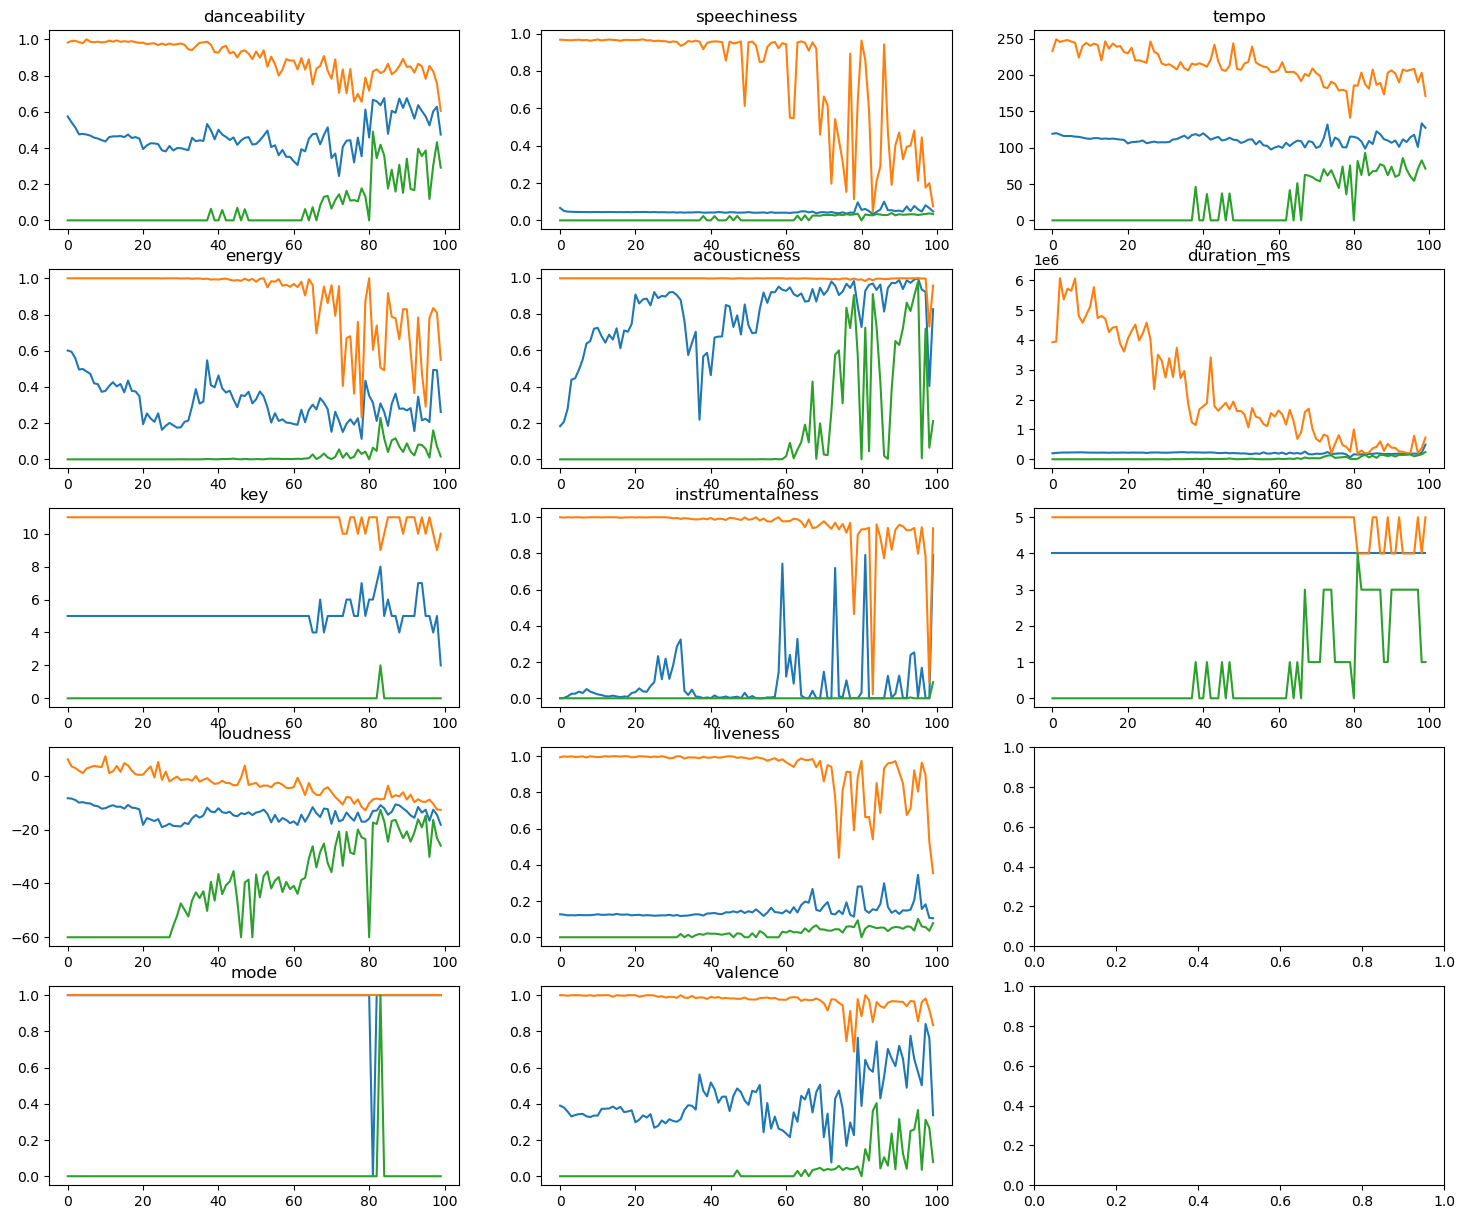

In [16]:
import numpy as np
# Approximate the median value of the "energy" column
print(len(data),len(median_data))

fig, ax = plt.subplots(5, 3,figsize=(18, 15))#, sharey=True)

# Iterate over the data series and plot each one in the corresponding subplot
for i in range(3):
    for j in range(5):
        data_idx = i * 5 + j
        if len(median_data)<= data_idx:
            break
        ax[j,i].plot(median_data[data_idx])
        ax[j, i].plot(time_pandas_max[f"max({data[data_idx]})"])
        ax[j, i].plot(time_pandas_min[f"min({data[data_idx]})"])
        ax[j,i].set_title(data[data_idx])

# Show the figure
plt.show()

In [17]:
sc.stop()